#  Прогнозирование заказов такси

## Описание проекта

Компании «Чётенькое такси» необходимо предоставить решение, позволяющее прогнозировать
количество заказов на следующий час для привлечения водителей в периодыпиковой нагрузки.

### Цель проекта:
На основании предоставленных исторических данных подобрать модель, предсказывающую количество предстоящих заказов. Метрикой качества принять *RMSE*, которое на тестовой выборке должно быть не больше 48. 

### Задачи проекта:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

### Описание данных
1. Данные лежат в файле `taxi.csv`. 
2. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

###  Этапы проекта:
- Исследование данных:
    - загрузка данных
    - оценка данных (типы переменных, типы категорий (номинативная, количественная))
- Предъобработка данных:
    - проверка и переименование названий столбцов
    - обработка дат
    - проверка и заполнение пропусков
    - проверка на дубликаты (полные, неполные)
    - проверка на мультиколлинеарность (выявление коррелированных столбцов, выборочное исключение при необходимости)
    - выявление и исключение аномальных значений (выводы внести в ТЗ приложения)
    - стратификация по близким признакам (при необходимости)
- Исследование данных на предмет применимости для машинного обучения
    - изучение признаков и целевой переменной
    - изучение распределений для количественных переменных (оценка формы, близость к нормальному)
    - изучение возможных взаимосвязей между независимыми и зависимой переменной
    - выбор функции связи и преобразование целевой переменной (при необходимости) 
    - кодирование номинативных переменных (с присвоением рангов, методом однопроходного кодирования)
    - масштабирование количественных переменных
- Машинное обучение с учителем
    - подготовка функции, реализующей выбор лучших гиперпараметров с использованием метода GridSearch и кроссвалидации, минимизирующей риски переобучения моделей
    - разделение обработанного ДФ на обучающую и тестовую повыборки 
    - подбор гиперпараметров с помощью метода кроссвалидации
    - проверка моделей на тестовой выборке
    - выбор лучщей модели с учетом критериев заказчика

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Подготовка

In [61]:
!pip install pygam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Загрузка библиотек

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from pygam import GAM, s, f, LogisticGAM
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from IPython.display import Markdown
from statsmodels.tsa.seasonal import seasonal_decompose

### Объявление функций

In [63]:
def search_best_params(features, target, model, params, random_state):
    #Формируем модель разбиения на подвыборки
    #cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=4, random_state = random_state)
    tscv = TimeSeriesSplit(n_splits = 5)
    
    #Формируем модель перебора гиперпараметров 
    G_models = GridSearchCV(model, params, scoring= 'neg_mean_squared_error', cv=tscv, n_jobs=-1, verbose=10)
    print("START fiting")
    G_models.fit(features, target)
    print(f"Grid searching finished")
    
   
    # #Проводим кроссвалидацию
    # print("START cross validation")
    # n_scores = cross_val_score\
    # (G_models, features, target, scoring= 'neg_mean_squared_error', cv=tscv, n_jobs=-1, verbose=10)
        
    # print(f"Grid searching finished")

    #Выводим статистики для метрики
    #print(f'mean RMSE: {(np.mean(abs(n_scores)))**0.5}, std RMSE: {(np.std(abs(n_scores)))**0.5}') 
      
    #Выводим лучшие гиперпараметры
    try:
        print(f'best params: {G_models.best_params_}')
        print(f'RMSE: {(abs(G_models.best_score_))**0.5}')
    except:
        print(f'проблемы с поиском лучшей модели')
     
    return (G_models, (abs(G_models.best_score_))**0.5)    

In [64]:
def write_results(all_results, dict_with_new_result):
    all_results['step'].append(dict_with_new_result.get('step'))
    all_results['model_name'].append(dict_with_new_result.get('model_name'))
    all_results['RMSE'].append(dict_with_new_result.get('RMSE'))
    all_results['feature_importances'].append(dict_with_new_result.get('feature_importances'))
    return all_results

In [65]:
def draw_features(model, x):
    
    fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
    fig.suptitle('Распределение значимости признаков', fontsize=14, fontweight='bold');
       
    sns.barplot(y = model.feature_importances_, x = x);

In [66]:
def try_on_test(model, model_name, train_f, train_t, test_f, test_t, results):
    
    #Обучение модели
    #model.fit(train_f, train_t)

    #Предсказание
    predict = model.predict(test_f)

    #Расчет метрик
    rmse = (mean_squared_error(test_t, predict))**0.5

    print(f' RMSE: {rmse}') 

    #Заполняем Словарь с результатами
    rez = {'step': 'test', 'model_name': model_name, 
       'RMSE': rmse}

    results = write_results(results, rez)
    return results

### Объявление констант

In [67]:
RANDSTATE = 7535689

### Загрузка данных

In [68]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/taxi.csv")

In [69]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


## Изучение данных

### Корректировка типов данных

In [70]:
data = data.astype({"datetime": "datetime64"})

### Проверка на наличие пропущенных значений

In [71]:
data.isna().sum()

datetime      0
num_orders    0
dtype: int64

### Проверка на наличие полных  дубликатов

In [72]:
data.duplicated().sum()

0

### Проверка на наличие неполных дубликатов

In [73]:
len(data.datetime.unique())

26496

### Изменение индекса для дальнейшего ресемплирования

In [74]:
res_data = copy.deepcopy(data)
res_data.set_index('datetime', drop=True, inplace=True)

In [75]:
res_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Ресемплирование

In [76]:
res_data = res_data.resample('1H').sum()

## Анализ данных

### Распределение целевой переменной

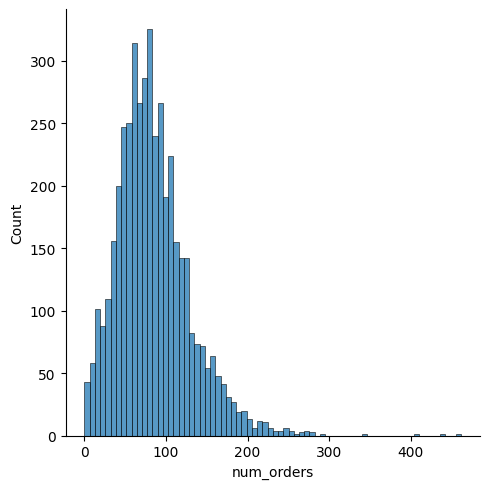

In [77]:
sns.displot(data= res_data.num_orders);

Судя по гистограмме распределение целевой переменной близко к нормальному.

### Проверка распределение на нормальность графическим способом

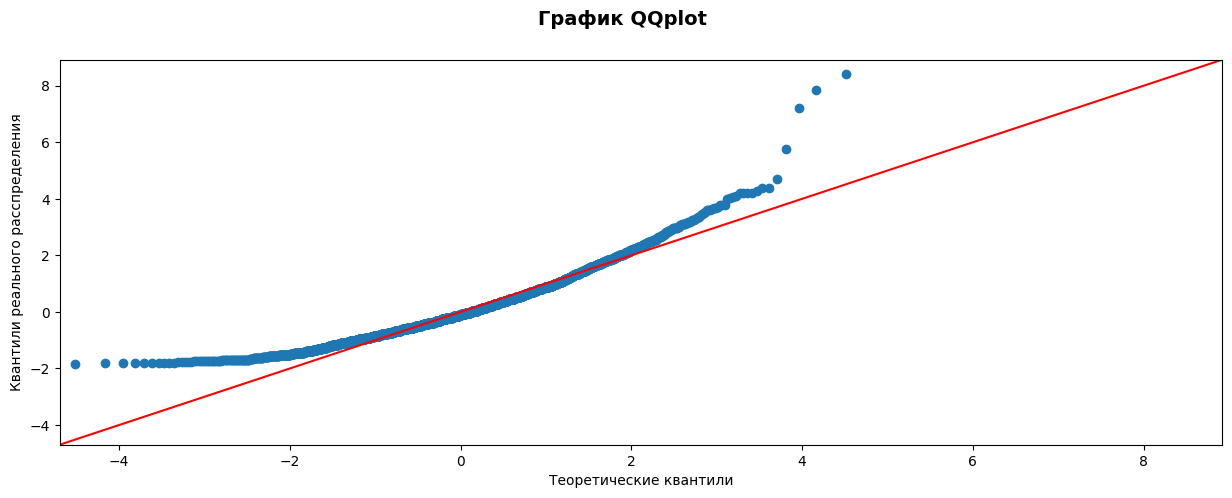

In [78]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

fig = sm.qqplot(res_data.num_orders, stats.t, fit=True, line="45", ax = axes)

fig.suptitle('График QQplot', fontsize=14, fontweight='bold');
axes.set_xlabel("Теоретические квантили");
axes.set_ylabel("Квантили реального расспределения"); 

Судя по по графику qqplot распределение целевой переменной действительно является нормальным если не учитывать зоны граничных выбросов.

### Ящик с усами

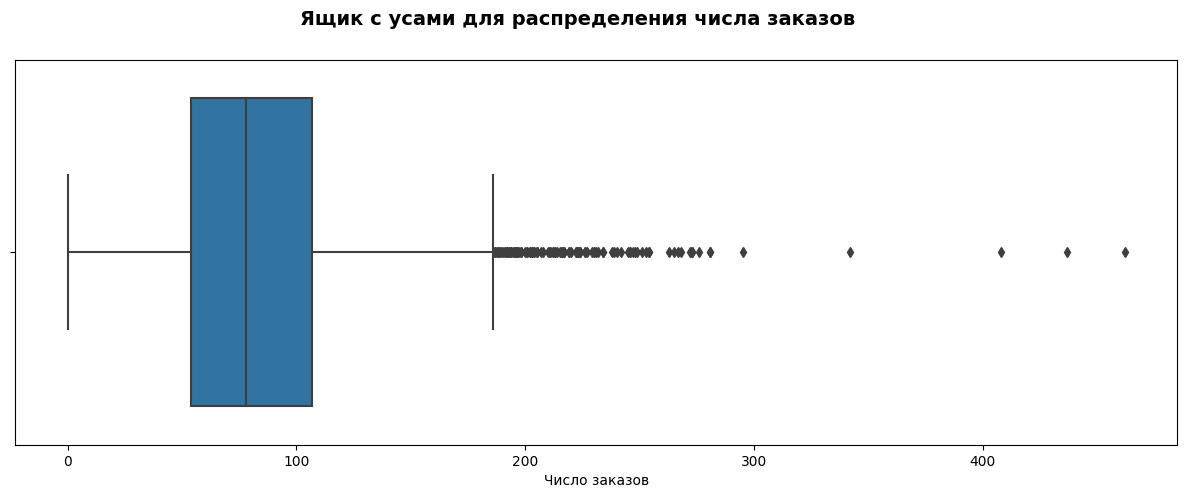

In [79]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.boxplot(data = res_data, x ='num_orders', ax = axes);

fig.suptitle('Ящик с усами для распределения числа заказов', fontsize=14, fontweight='bold');
axes.set_xlabel("Число заказов");
axes.set_ylabel(""); 

### Зависимость целевой переменной от времени

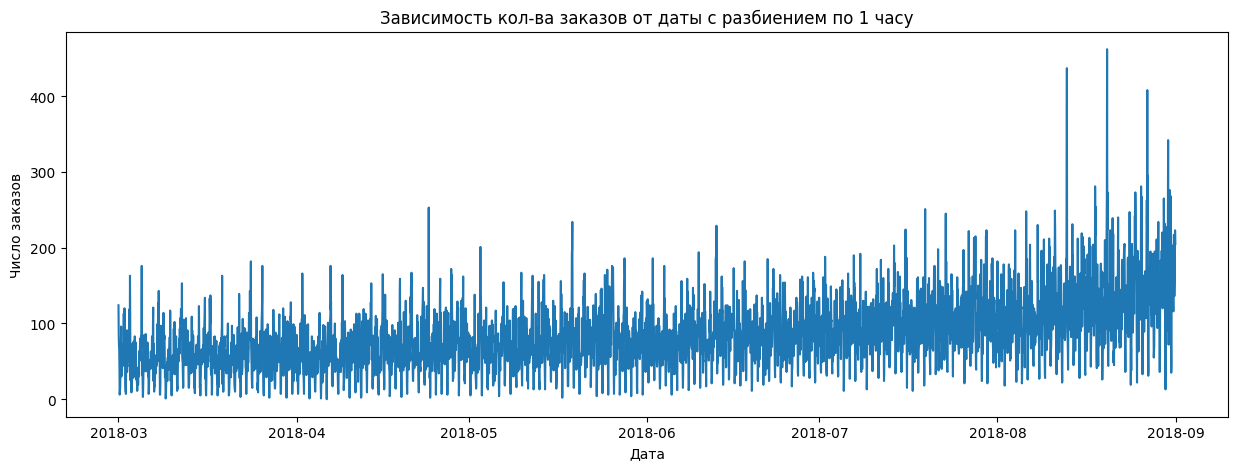

In [80]:
fig, axes = plt.subplots(1, 1, sharey=True, figsize = (15, 5))
axes.set(title = 'Зависимость кол-ва заказов от даты с разбиением по 1 часу', xlabel = 'Дата', ylabel = 'Число заказов')
sns.lineplot(data = res_data, x = 'datetime', y = 'num_orders', ax = axes);

Построенный график для визульного анализа мало информативен. Посмотрим натренды и сезонность.

### Сезонность суточная

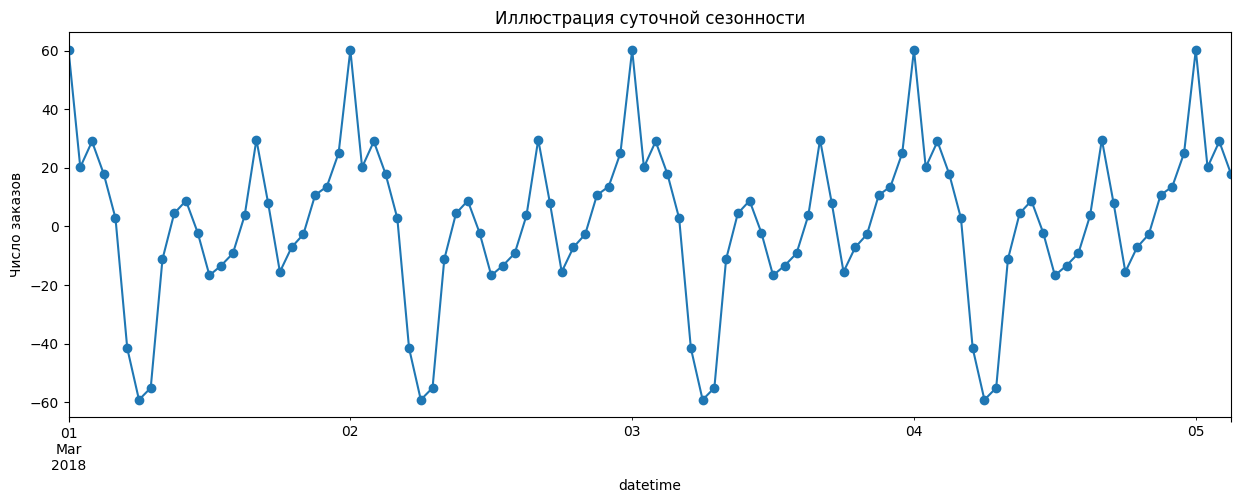

In [81]:
res_data.sort_index(inplace=True)
decomposed = seasonal_decompose(res_data['num_orders'])

fig, axes = plt.subplots(1, 1, sharey=True, figsize = (15, 5))
axes.set(title = 'Иллюстрация суточной сезонности', xlabel = 'Дата', ylabel = 'Число заказов')
decomposed.seasonal[0:100].plot(ax = axes, style = 'o-');

По графику видно, что нагрузка на такси изменяется по некому повторяющемуся закону и имеет постоянные провалы длительностью 3-4 часа.

### Сезонность недельная

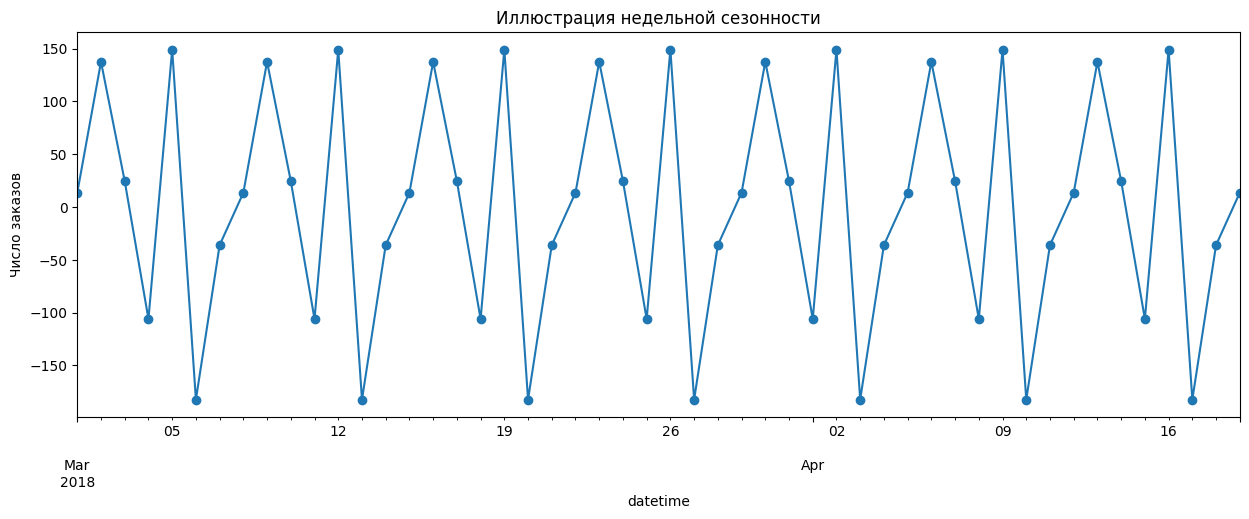

In [82]:
decomposed = seasonal_decompose(res_data.resample('1D').sum()['num_orders'])

fig, axes = plt.subplots(1, 1, sharey=True, figsize = (15, 5))
axes.set(title = 'Иллюстрация недельной сезонности', xlabel = 'Дата', ylabel = 'Число заказов')
decomposed.seasonal[0:50].plot(ax = axes, style = 'o-');

По графику видно, что нагрузка на такси изменяется по некому повторяющемуся закону и имеет постоянные провалы каждые 7 дней.

### Тренд

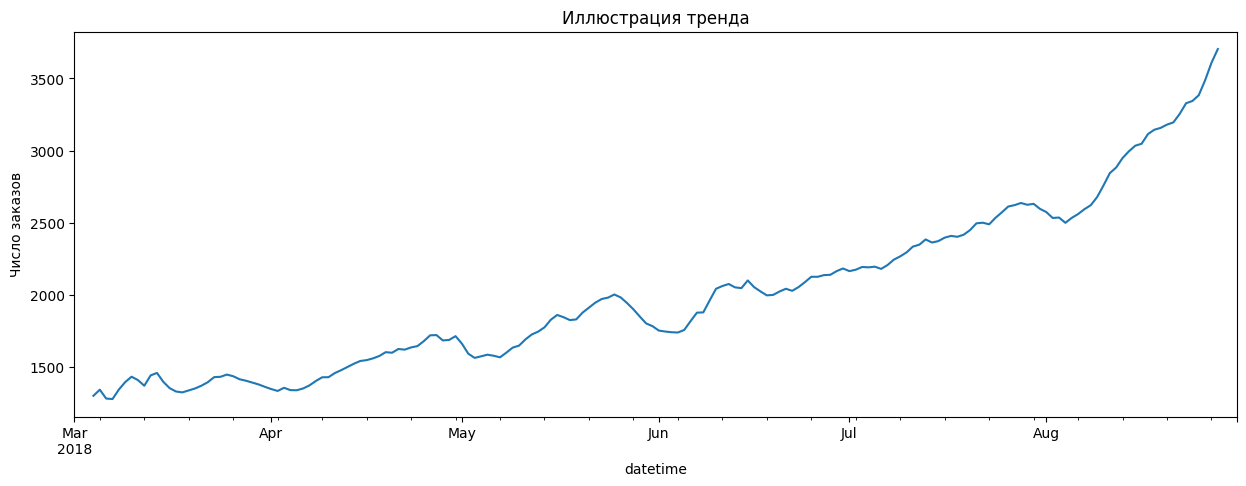

In [83]:
fig, axes = plt.subplots(1, 1, sharey=True, figsize = (15, 5))
axes.set(title = 'Иллюстрация тренда', xlabel = 'Дата', ylabel = 'Число заказов')
decomposed.trend.plot(ax = axes, style = '-');

Судя по графику на нашей выборке мы видим восходящий тренд. Что позволяет предположить, что рассматриваемый временной ряд не является стационарным (медиана целевой переменной не является постоянной, а возрастает со временем). Изобразим медиану и дисперсию скользящего среднего с окном в сутки.

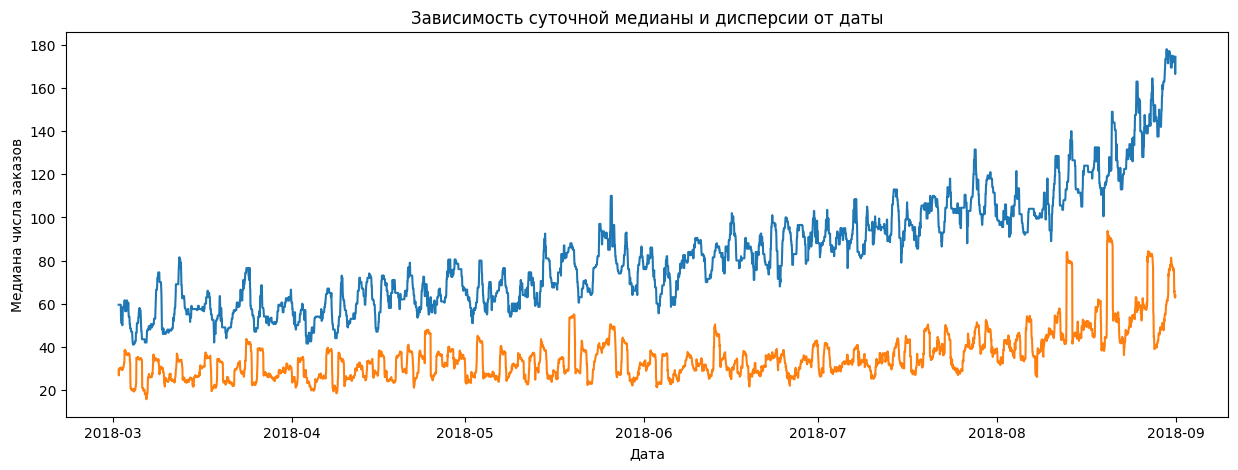

In [84]:
fig, axes = plt.subplots(1, 1, sharey=True, figsize = (15, 5))
axes.set(title = 'Зависимость суточной медианы и дисперсии от даты', xlabel = 'Дата', ylabel = 'Медиана числа заказов')
sns.lineplot(data = res_data, x = 'datetime', y = res_data.num_orders.shift().rolling(24).median(), ax = axes);
sns.lineplot(data = res_data, x = 'datetime', y = res_data.num_orders.shift().rolling(24).std(), ax = axes);

По графикам видно, что медиана времееного ряда непостоянна и действительно растет со временем. Дисперсия же относительно стабильна. Вместе с тем на короткой дистанции (до 1 месяца) медиана практически не меняется. Что вместе с обозначенным заказчиком горизонтом планирования (1 час) является достаточным основанием считать ряд стационарным. Проверим его стационарность статистическим критерием.  

### Проверка на стационарность ряда с помощью критерия Дикки-Фуллера

По графику тренда (схожему с параболой) и медианы временного ряда можно предположить, что рассматриваемый ряд не стационарен и содержит тренд, изменяющийся по квадратичному закону.Проверим эту гипотезу спомощью критерия Дикки-Фуллера.

In [85]:
st_test = adfuller(res_data.num_orders, regression='ct')

display(Markdown(f'\n **Результаты теста Дикки-Фуллера:** \n\
1. Статистика (adf): {st_test[0]}, \n\
2. pvalue:           {st_test[1]}, \n\
3. Доверительные интервалы (critical values):  {st_test[4]}, \n'))

if st_test[1] > 0.05:
    print("Гипотеза о наличии презнаков нестационарности не может быть отвергнута. Ряд вероятно нестационарен")
else:
    print("Есть статистически значимые основания отвергнуть гипотезу о наличии нестационарных признаков. Ряд вероятно стационарен")
    


 **Результаты теста Дикки-Фуллера:** 
1. Статистика (adf): -8.326521572379836, 
2. pvalue:           1.2583924361802465e-11, 
3. Доверительные интервалы (critical values):  {'1%': -3.960836041046122, '5%': -3.4114917019432394, '10%': -3.127639850914672}, 


Есть статистически значимые основания отвергнуть гипотезу о наличии нестационарных признаков. Ряд вероятно стационарен


Так как статистика ADF теста близка к рассчитанным доверительным интервалам, а pvalue меньше критерия значимости мы не можем отвергнуть нулевую гипотезу и вынуждены исходить из того, что рассматриваемый ряд стационарен.

### Выбор оптимальных параметров для скользящего среднего

Для выбора оптимальных параметров скользящего среднего используем функцию автокорреляции (ACF), определяющую корреляцию между наблюдениями в текущий момент времени и наблюдениями за все предыдущие моменты. 

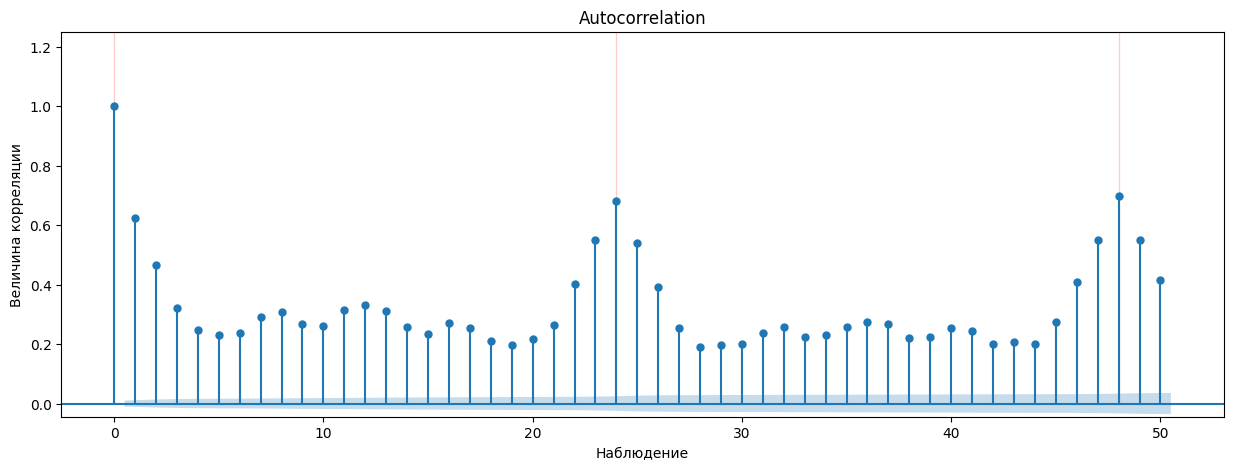

In [86]:
fig, axes = plt.subplots(1, 1, sharey=True, figsize = (15, 5))
axes.set(title = 'Функция автокорреляции (ACF)', xlabel = 'Наблюдение', ylabel = 'Величина корреляции')
plot_acf(res_data, alpha = 0.5, auto_ylims = True, lags = 50,  ax = axes).set_size_inches(15, 5)
sns.lineplot(x= 0, y = range(0, 3), color = 'red')
sns.lineplot(x= 24, y = range(0, 3), color = 'red')
sns.lineplot(x= 48, y = range(0, 3), color = 'red');

На автокорреляционной функции мы видим суточную сезонности (отрезки между красными линиями). Внутри суток также наблюдаются незначительные колебания кореляции. В идеале надо взять такое скользящее среднее, которое полностью захватит один период повторения максимумов корреляционной функции. Близкое к оптимальному число наблюдений равно 24. 

### Выбор оптимальных параметров для авторегрессии

Определим оптимальное количество отстающих значений, на основании которых стоит строить предсказания для линейной регрессии. Для этого построим график функции частичной корреляции (PACF), который отображает корреляцию между двумя моментами времени с учетом любых влияний со стороны других точек данных.

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


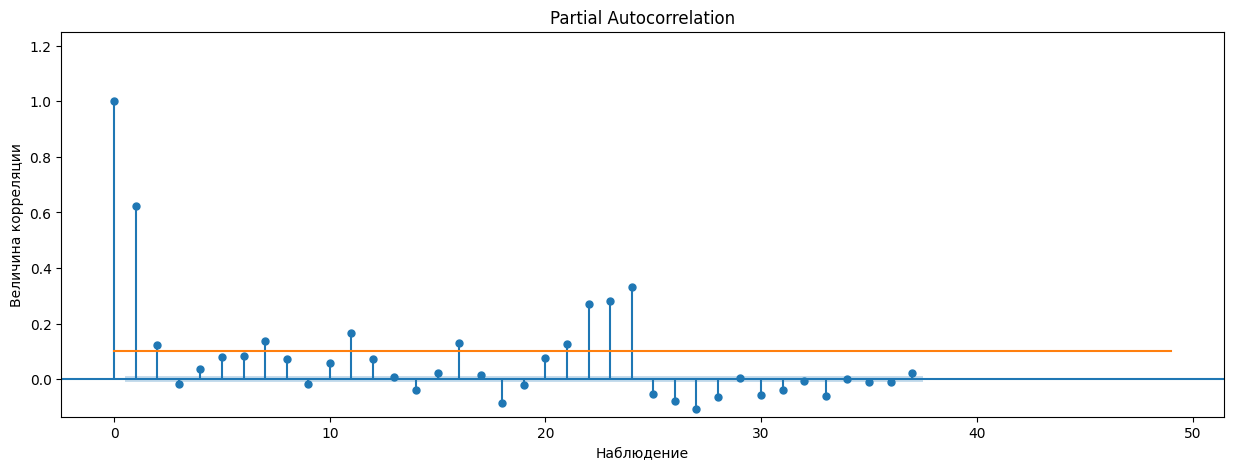

In [87]:
fig, axes = plt.subplots(1, 1, sharey=True, figsize = (15, 5))
axes.set(title = 'Функция автокорреляции (ACF)', xlabel = 'Наблюдение', ylabel = 'Величина корреляции')
plot_pacf(res_data, alpha = 0.5, auto_ylims = True,  ax = axes).set_size_inches(15, 5)
sns.lineplot(x= range(0,50), y = 0.1);

В идеале надо взять кол-во отстающих значений, равное кол-ву далеких от нуля значений функции. Критерий "удаленности" примем равным 0.1. Близкое к оптимальному число наблюдений равно 10. 

### Добавление в данные скользящего средего за 24 часа

In [88]:
res_data['rolling_mean'] = res_data.num_orders.shift().rolling(24).mean()

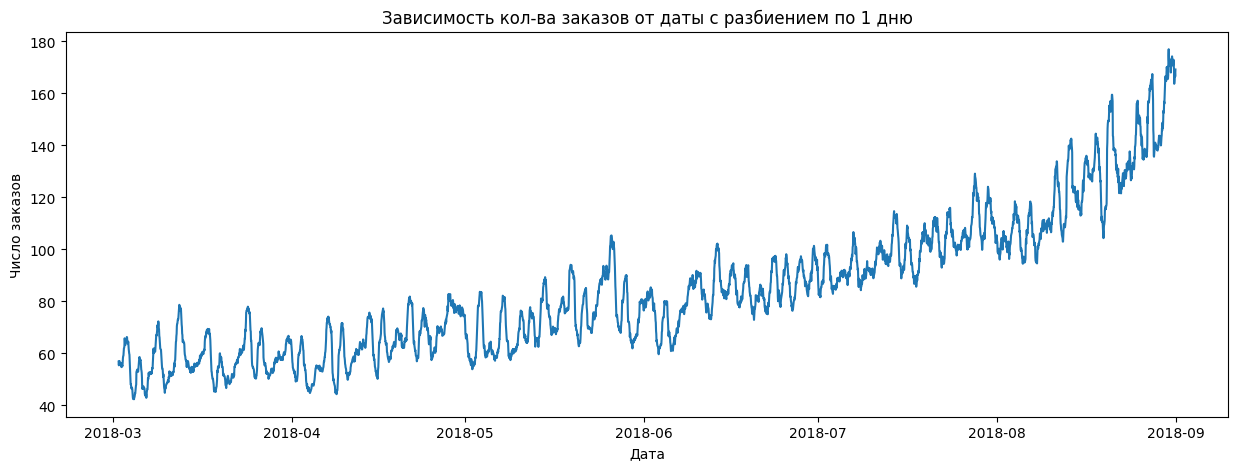

In [89]:
fig, axes = plt.subplots(1, 1, sharey=True, figsize = (15, 5))
axes.set(title = 'Зависимость кол-ва заказов от даты с разбиением по 1 дню', xlabel = 'Дата', ylabel = 'Число заказов')
sns.lineplot(data = res_data, x = 'datetime', y = 'rolling_mean', ax = axes);

 Для уточнения характера зависимости целевой переменной от дня недели и времени суток добавим в данные дополнительные столбцы.

### Добавление в данные календарных данных

In [90]:
#Добавление в данные столбцов с месяцем, днем недели, часом, временем суток
res_data['week_day'] = pd.DatetimeIndex(res_data.index).weekday
res_data['month'] = pd.DatetimeIndex(res_data.index).month
res_data['hour'] = pd.DatetimeIndex(res_data.index).hour
res_data['time_of_day'] = res_data.hour.transform\
(lambda x:(\
           ((x > 4 and x < 9) and 'morning') or \
           ((x > 9 and x < 18) and 'day') or \
           ((x > 18 and x < 22) and 'evening') or \
            'night'
          ))

### Связь с месяцем

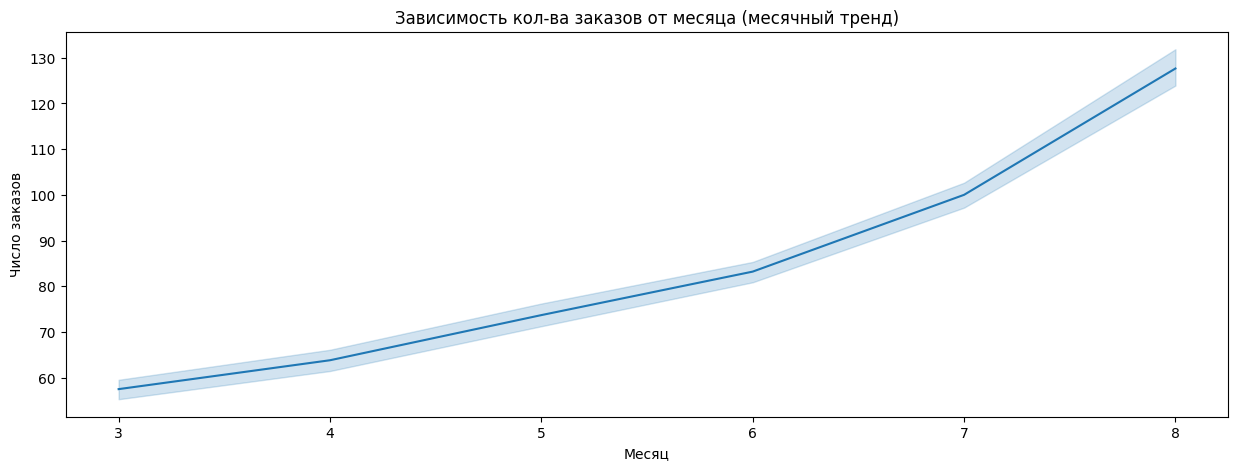

In [91]:
fig, axes = plt.subplots(1, 1, sharey=True, figsize = (15, 5))
axes.set(title = 'Зависимость кол-ва заказов от месяца (месячный тренд)', xlabel = 'Месяц', ylabel = 'Число заказов')
sns.lineplot(data = res_data, x = 'month', y = 'num_orders', ax = axes);

По графику для скользящего среднего четко видна тенденция: среднее количество заказов в день в рассмотренном срезе данных плавно растет с марта 2018 года по сентябрь 2018 года. Однако мы не можем с уверенностью утверждать, что это - тенденция, связанная с особенностями спроса в целом (то есть целевая переменная продолжит и дальше расти) или некое сезонное явление (и, например, в октябре спрос на такси понизится).

### Связь с днем недели

In [92]:
#Группировка (день недели)
order_by_day = res_data\
.groupby(by = 'week_day', as_index = False)\
.agg(num_orders = ('num_orders', 'mean')).sort_values(by = 'num_orders', ascending = False)

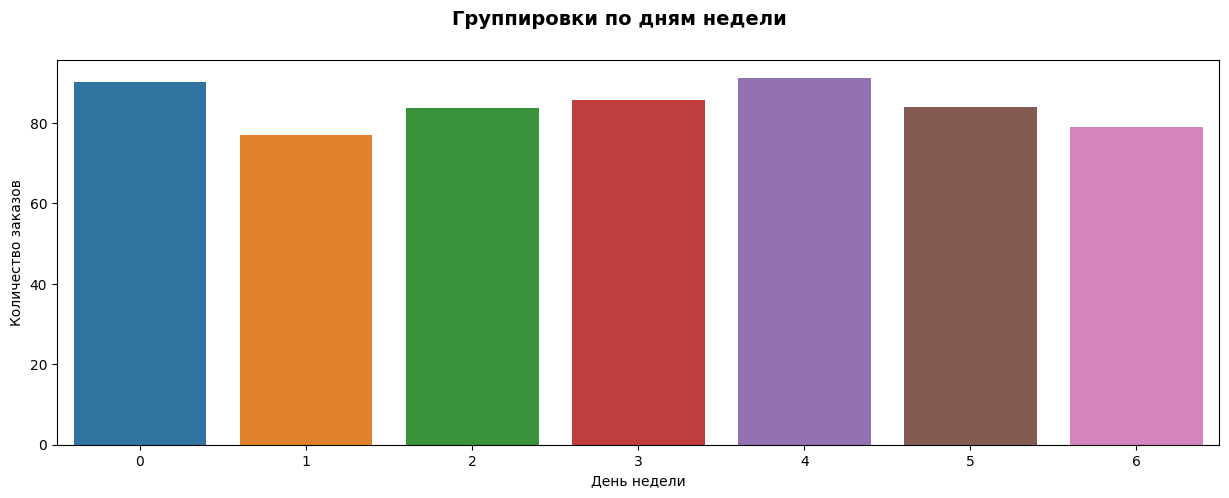

In [93]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.barplot(y = order_by_day.num_orders, x = order_by_day.week_day);

fig.suptitle('Группировки по дням недели', fontsize=14, fontweight='bold');
axes.set_xlabel("День недели");
axes.set_ylabel("Количество заказов"); 

По графику видно, что количество заказов в целом достаточно равномерно распределено между днями недели 

### Связь с временем суток

In [94]:
#Группировка (время суток)
order_by_time = res_data\
.groupby(by = 'time_of_day', as_index = False)\
.agg(num_orders = ('num_orders', 'mean')).sort_values(by = 'num_orders', ascending = False)

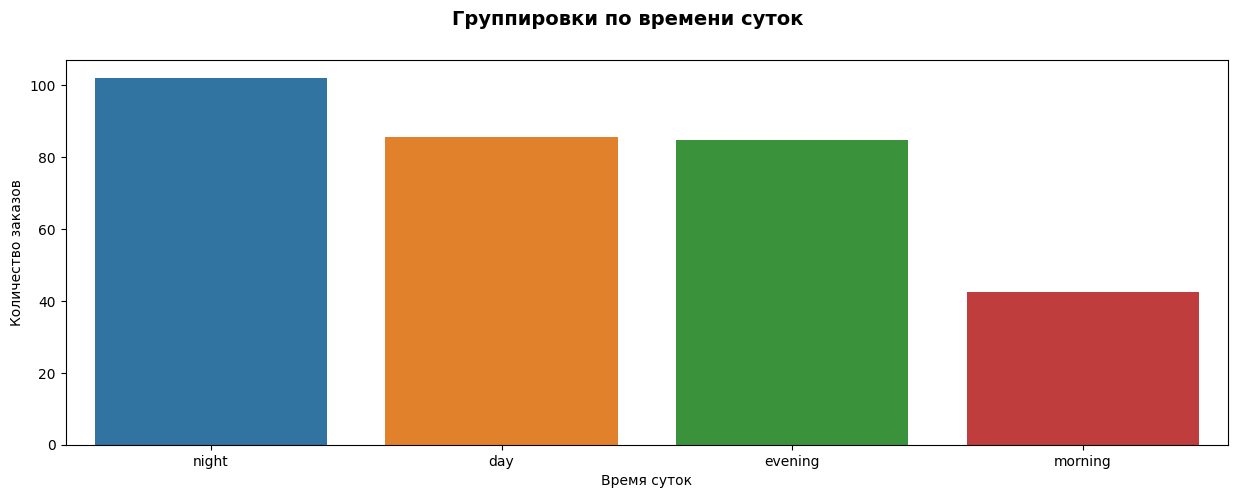

In [95]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.barplot(y = order_by_time.num_orders, x = order_by_time.time_of_day);

fig.suptitle('Группировки по времени суток', fontsize=14, fontweight='bold');
axes.set_xlabel("Время суток");
axes.set_ylabel("Количество заказов"); 

По графику видно, что количество заказов досточно сильно зависит от времени суток. Так, в понедельник количество заказов значительно "проседает"

### Взаимное влияние времени суток и дня недели на кол-во заказов

In [96]:
#Комбинированная группировка (день недели - время суток)
order_by_daytime = res_data\
.groupby(by = ['week_day','time_of_day'], as_index = [False, False])\
.agg(num_orders = ('num_orders', 'mean')).sort_values(by = 'num_orders', ascending = False)

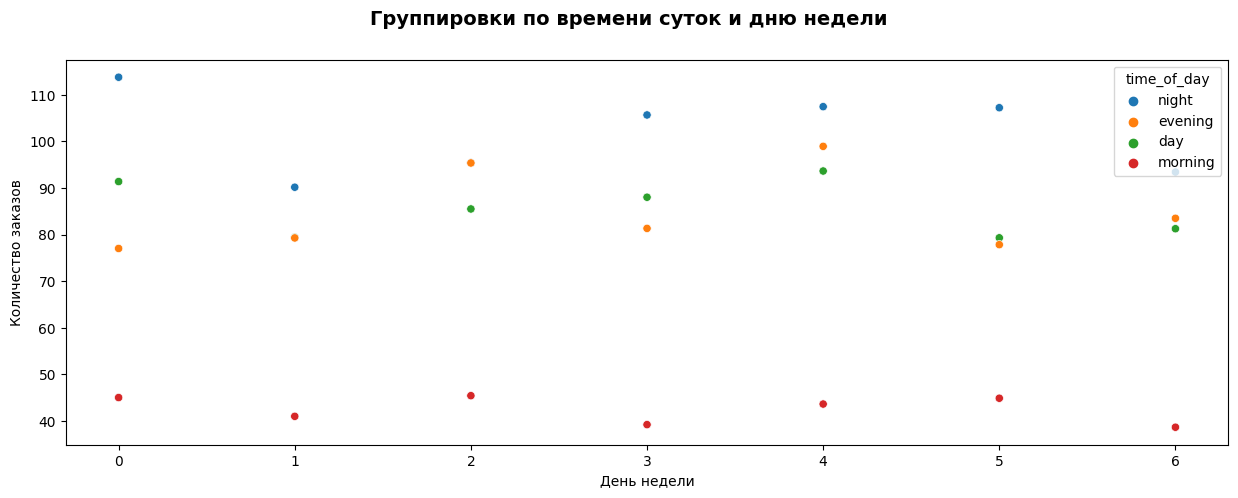

In [97]:
#Визуализация группировки
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))

sns.scatterplot(data = order_by_daytime,  x = 'week_day', y = 'num_orders', hue = 'time_of_day')

fig.suptitle('Группировки по времени суток и дню недели', fontsize=14, fontweight='bold');
axes.set_xlabel("День недели");
axes.set_ylabel("Количество заказов"); 

По диаграмме рассеяния видно, что количество заказов по утрам вцелом не зависитот дня недели. Вместе с тем, кол-во заказов по ночам достаточно сильно зависит от дня недели. Так по воскресеньям оно резко возрастает, а по понедельникам - падает.

С учетом изложенного, информативными для исследования стоит считать следующие столбцы:
- week_day      
- hour
- time_of_day_cat
- rolling_mean.

Столбец month целесообразно удалить.

### Добавление отстающих значений

Для предоставления модели данных о направлении изменения целевого параметра добавим в данные отсающие значения в количестве, определенном на этапе EDA.

In [98]:
for lag in range(1, 11):
    res_data[f'lag_{lag}'] = res_data.num_orders.shift(lag) 


### Удаление лишних столбцов

In [99]:
res_data = res_data.drop('month', axis = 1)

In [100]:
res_data = res_data.dropna()

### Определение названий столбцов с признаками

In [101]:
x_all = ['rolling_mean', 'week_day', 'hour', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9',
       'lag_10', 'day', 'evening', 'morning', 'night']

## Подготовка признаков для обучения

### Разделение на обучающую и тестовую выборки

In [102]:
target = res_data.num_orders
features = res_data.drop(['num_orders'], axis = 1)

In [103]:
train_t, test_t, train_f, test_f = \
train_test_split(target, features, test_size = 0.1, random_state = RANDSTATE, shuffle = False)

### Кодирование и масштабирование данных

Так как масштабирование требуется толькодля моделей линейной регрессии, сделаем три разных набора данных:
1. С мастабированными признаками
2. С неизменными признаками

Также отметим, что признаки, связанные с датой и временем масштабированию не подлежат.
Таким образом необходимо:
- масштабировать rolling_mean и lags
- закодировать время суток методом OHE

#### Масштабирование 

In [104]:
sc_train_t, sc_test_t, sc_train_f, sc_test_f = \
train_test_split(target, features, test_size = 0.1, random_state = RANDSTATE, shuffle = False)

#Масштабирование данных методом StandartScaler
scaler_cols = ['rolling_mean', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
scaler = StandardScaler()
sc_train_f.loc[:, scaler_cols] = scaler.fit_transform(sc_train_f[scaler_cols])
sc_test_f.loc[:, scaler_cols] = scaler.transform(sc_test_f[scaler_cols])

### Кодирование данных методом OHE

In [105]:
#Функция для Кодирования всех выборок
def ohe_coder(data, coder):
    coded = coder.transform(data['time_of_day'])
    coded_df = pd.DataFrame(coded, columns = ['day', 'evening', 'morning', 'night'], index = data.index)
    data = pd.concat([data, coded_df], axis=1).drop(['time_of_day'], axis=1)
    return data

In [106]:
coder = LabelBinarizer()
coder.fit(sc_train_f['time_of_day']);

In [107]:
sc_train_f = ohe_coder(sc_train_f, coder)
sc_test_f = ohe_coder(sc_test_f, coder)
train_f = ohe_coder(train_f, coder)
test_f = ohe_coder(test_f, coder)

### Словарь для сохранения результатов обучения моделей

In [108]:
#Словарь, который будет аккумулировать результаты
results = {'step': [], 'model_name': [], 'RMSE': [],'feature_importances': []}

## Подбор моделей

### ElasticNet

In [109]:
#Создание объекта модели
el_model = ElasticNet(random_state = RANDSTATE)
el_params = {'max_iter': range(500, 1000, 250), 'alpha':[0.2, 0.5, 1], 'selection': ('cyclic', 'random')}

(el_best_model, RMSE) = search_best_params(sc_train_f, sc_train_t, el_model, el_params, RANDSTATE)

#Заполняем Словарь с результатами
rez = {'step': 'train', 'model_name': 'ElasticNet', 
       'RMSE': RMSE}

results = write_results(results, rez)

START fiting
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Grid searching finished
best params: {'alpha': 0.2, 'max_iter': 500, 'selection': 'cyclic'}
RMSE: 30.452438332012214


### DecisionTreeRegressor

In [110]:
dt_model = DecisionTreeRegressor()
dt_params = {'splitter': ('best', 'random'), 'max_depth': range(50, 200, 10), 
             'min_samples_split': range(2, 10, 2), 'min_samples_leaf': range(2, 10, 2)}

(dt_best_model, RMSE) = search_best_params(train_f, train_t, dt_model, dt_params, RANDSTATE)

#Заполняем Словарь с результатами
rez = {'step': 'train', 'model_name': 'DecisionTreeRegressor', 
       'RMSE': RMSE, 
       'feature_importances': dt_best_model.best_estimator_.feature_importances_}

results = write_results(results, rez)

START fiting
Fitting 5 folds for each of 480 candidates, totalling 2400 fits
Grid searching finished
best params: {'max_depth': 50, 'min_samples_leaf': 8, 'min_samples_split': 8, 'splitter': 'random'}
RMSE: 28.114460406400564


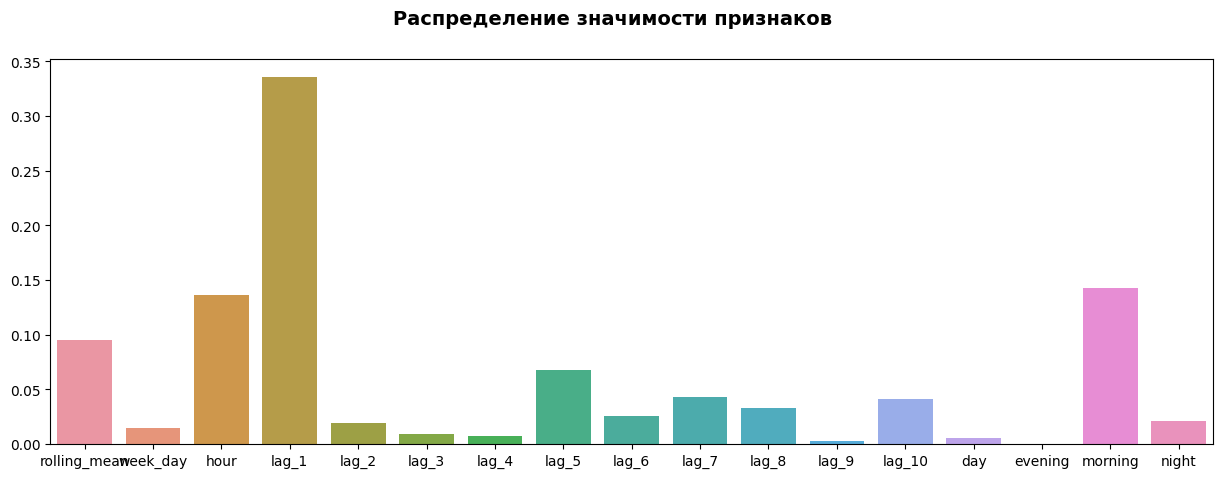

In [111]:
draw_features(dt_best_model.best_estimator_,x_all)

### RandomForestRegressor

In [112]:
rfr_model = RandomForestRegressor()

rfr_params = {'n_estimators': range(50, 100, 25), 
              'max_depth': range(50, 200, 50), 'min_samples_split': range(2, 10, 2), 
              'min_samples_leaf': range(2, 10, 2)}

(rfr_best_model, RMSE) = \
search_best_params(train_f, train_t, rfr_model, rfr_params, RANDSTATE)

#Заполняем Словарь с результатами
rez = {'step': 'train', 'model_name': 'RandomForestRegressor', 
       'RMSE': RMSE, 
       'feature_importances': rfr_best_model.best_estimator_.feature_importances_}

results = write_results(results, rez)

rfr_best_model = rfr_best_model.best_estimator_

START fiting
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Grid searching finished
best params: {'max_depth': 100, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 75}
RMSE: 25.33907598601416


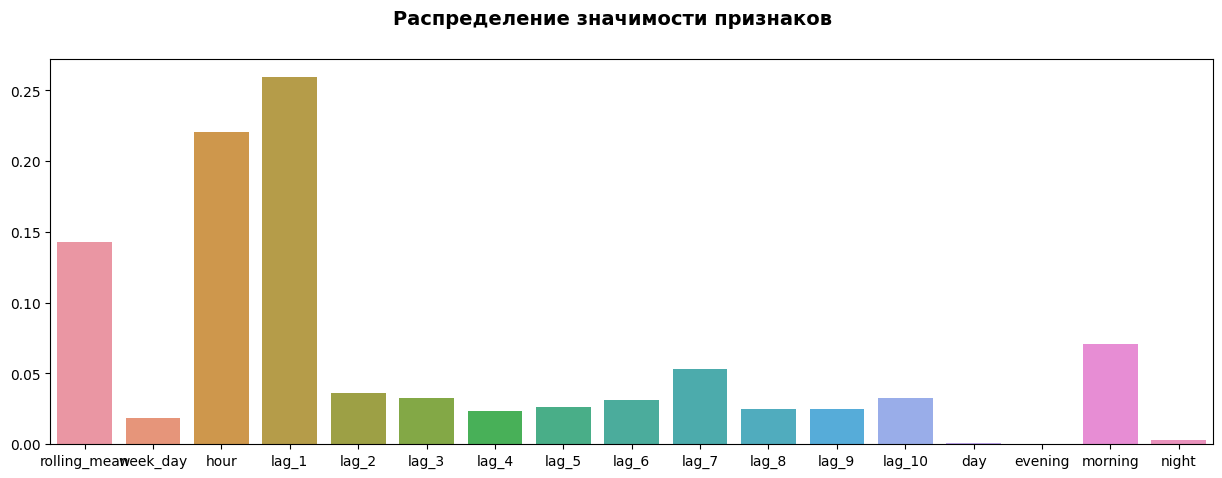

In [113]:
draw_features(rfr_best_model, x_all)

### GAM

In [114]:
#Генерируем случайные комбинации для коэффициентов сплайнов
spline = np.arange(3, 5, 1)
splines = [spline]*3

In [115]:
#Подбор параметров
gam_model = GAM(s(0)+s(1)+s(2)).gridsearch(sc_train_f.values, sc_train_t, n_splines = splines)

#Обучение модели
gam_model.fit(sc_train_f, sc_train_t)

#Предсказание
train_predict = gam_model.predict(sc_train_f)

#Расчет метрики
train_gam_rmse = (mean_squared_error(sc_train_t, train_predict))**0.5

#Заполняем Словарь с результатами
rez = {'step': 'train', 'model_name': 'GAM', 
       'RMSE': train_gam_rmse}

results = write_results(results, rez)

100% (8 of 8) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


## Сравнение моделей



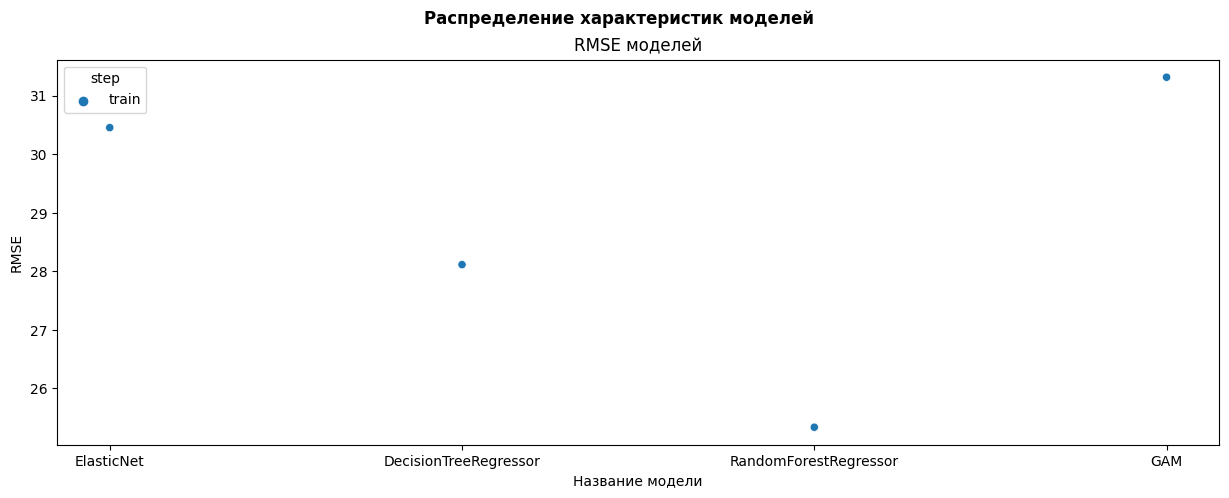

In [116]:
df_results = pd.DataFrame(results)
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
fig.suptitle('Распределение характеристик моделей', fontsize=12, fontweight='bold');
sns.scatterplot(y =  df_results.RMSE, x = df_results.model_name, ax = axes, hue = df_results.step);

axes.set_xlabel("Название модели");
axes.set_ylabel("RMSE");
axes.set(title = "RMSE моделей");

In [117]:
best_RMSE = df_results.query('step == "train"').RMSE.min()
best_model =  df_results.query('step == "train" and RMSE == @best_RMSE')
display(Markdown(f'\n По результатам сравнение метрик качества установлено, \
что лучшей моделью является **{best_model.model_name.values[0]}**\n'))    
display(Markdown(f'\n c RMSE на тренировочной выборке **{best_model.RMSE.values[0]}.**\n'))


 По результатам сравнение метрик качества установлено, что лучшей моделью является **RandomForestRegressor**



 c RMSE на тренировочной выборке **25.33907598601416.**


## Тестирование

### RandomForestRegressor

In [121]:
results = try_on_test(rfr_best_model, 'RandomForestRegressor', \
                      train_f, train_t, test_f, test_t, results)

 RMSE: 43.66902652411529


## Выводы

### Визуализация абсолютной ошибки

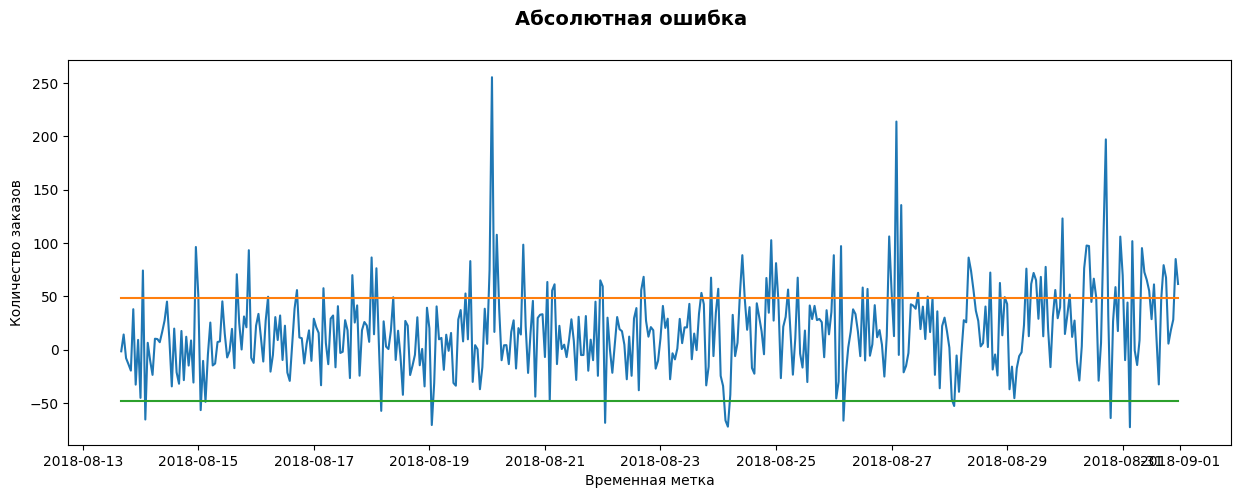

In [119]:
predict = rfr_best_model.predict(test_f)
predict_df = pd.DataFrame({"predict": predict, "target": test_t})
predict_df['error'] = predict_df.target - predict_df.predict

#Визуализация результатов предсказания
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
sns.lineplot(data=predict_df, x = list(predict_df.index), y = 'error')
sns.lineplot(x = list(predict_df.index), y = 48)
sns.lineplot(x = list(predict_df.index), y = -48)

fig.suptitle('Абсолютная ошибка', fontsize=14, fontweight='bold');
axes.set_xlabel("Временная метка");
axes.set_ylabel("Количество заказов"); 

Видно, что ближе к концу выборки предсказание становится менее точным, что не критично. Модель должна предсказывать число заказов лишь на час вперед.

### Сравнительная визуализация фактических и предсказанных значений

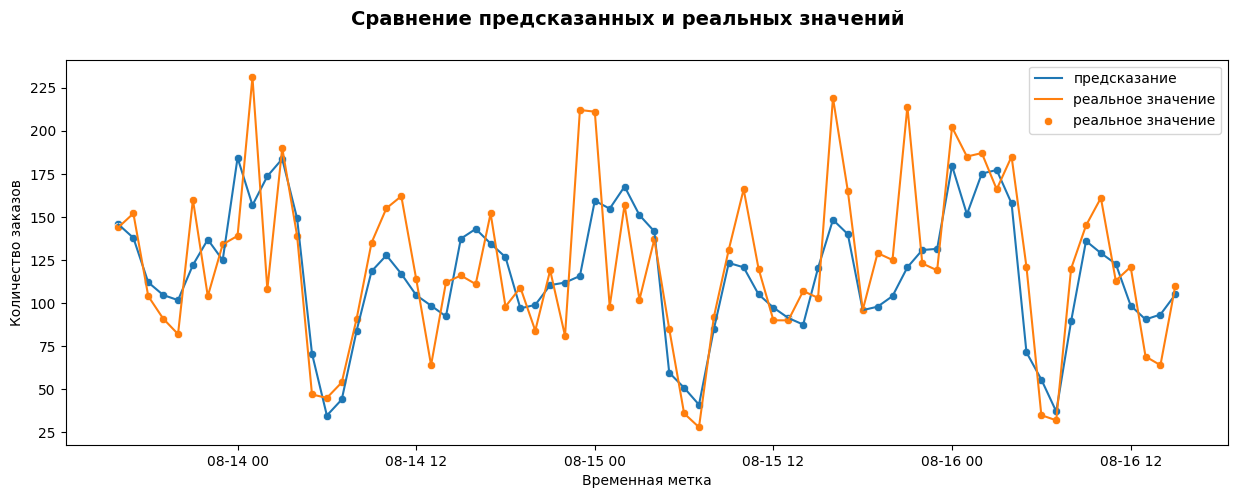

In [120]:
#Визуализация результатов предсказания
samples = 72
fig, axes = plt.subplots(nrows = 1, ncols = 1, sharey = False, figsize = (15, 5))
sns.lineplot(data=predict_df.iloc[0:samples,:], \
             x = list(predict_df.index)[0:samples], y = 'predict', \
             label = "предсказание")
sns.lineplot(data=predict_df.iloc[0:samples,:], \
             x = list(predict_df.index)[0:samples], y = 'target', \
             label = "реальное значение", markers=True)
sns.scatterplot(data=predict_df.iloc[0:samples,:], \
             x = list(predict_df.index)[0:samples], y = 'predict')
sns.scatterplot(data=predict_df.iloc[0:samples,:], \
             x = list(predict_df.index)[0:samples], y = 'target', \
             label = "реальное значение", markers=True)

fig.suptitle('Сравнение предсказанных и реальных значений', fontsize=14, fontweight='bold');
axes.set_xlabel("Временная метка");
axes.set_ylabel("Количество заказов"); 

Получившаяся модель "сглаживает" выбросы реальных данных. Но в целом ее предсказания достаточно правильно отображают основные тенденции изменения спроса на такси.

## Выводы по результатам исследования

Целью исследования было подготовить модель расчета количества заказов такси на следующий час. Модель должна была быть разработана на основании исследования исторических данных о ранее сделанных заказах(предосталены в csv файле). Показателем качества модели требовалось принять RMSE, которая должна быть меньше 48 на тестовых данных. 
При выборе модели важны:
- точность предсказания

В процесе исследования:
1. Загружены и изучены исторические данные о сделанных заказах  
2. Исследованы загруженные данные, определена их форма, типы, смысловая нагрузка
3. Выполнен EDA, включая:
     - проверку корректности назначенных типов данных (изменены столбецы с датами)
     - поиск полных и неявных дубликатов (не выявлены) 
     - поиск и заполнение пропусков (не выявлены)
     - выявление аномальных значений (не выявлены)
     - изучение характерных взаимосвязей, выявлена:
         - слабая связь между количеством заказов и днем недели;
         - весомая связь между количеством заказов и временем суток;
         - положительная линейная связь между количеством заказов и месяцем; 
4. Проведена подготовка данных к машинному обучению:
  - в данные добавлены календарные признаки (деньнедели, час, месяц, время суток, скользящее среднее с окном в три часа)
  - сформированы списки зависимых и независимых признаков для машинных моделей:
  - выборка разделена на обучающую и тестовую;
  - проведено масштабирование количественных признаков методом preprocessing.StandartScaler
5. Подготовлена функция, автоматизирующая перебор гиперпараметров на основе метода GridSearch и кросс-валидации с использованием временного сплиттера TimeSeriesSplit.
6. Подготовлены вспомогательные функции для:
   - заполнения ДФ срезультатами
   - визуализации значимости признаков
   - тестирования моделей на тестовой выборке
7. Проведено машинное обучение:
     - созданы модели:
        - ElasticNet
        - DecisionTreeRegressor
        - RandomForestRegressor
        - GAM
     - подобраны гиперпараметры для указанных моделей, оценена метрика качества, полученная на обучающей выборке
     - модели с оптимальными гиперпараметрами проверены на тестовой выборке. 

8.По результатам сравнение результатов, установлено, что лучшей моделью является RandomForestRegressor c RMSE на тестовой выборке 43.66
